# Task for Today  

***

## Restaurant Tip Prediction  

Given *data about transactions at a restaurant*, let's try to predict the **tip** a given customer will leave.

We will use a linear regression model to make our predictions.

# Getting Started

In [1]:
import numpy as np
import pandas as pd

# 그래프 표현
import matplotlib.pyplot as plt

# 그래프 표현 (matplot 기반)
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.model_selection import KFold

# 이게 sklearn에서 제공하는 메소드, 예를 들어 억대인 값들도 0~1로 스케일 해준다.
# 이것의 문제점은, 이건희 같은 사람이 들어와서 혼자서 600억 이러고, 나머지 연봉은 1,2억 하면 하나만 튄다.
# 즉, 하나만 너무 높게 나오고 나머지는 다 0으로 가깝게 수렴해 버린다.
# 그래서 이런 부분이 데이터 사이언티스트의 손에 의해 잘 결정되어야 한다.
# 데이터마다
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression

In [4]:
data = pd.read_csv('./tips.csv')

In [10]:
data

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   total_bill  244 non-null    float64
 1   tip         244 non-null    float64
 2   sex         244 non-null    object 
 3   smoker      244 non-null    object 
 4   day         244 non-null    object 
 5   time        244 non-null    object 
 6   size        244 non-null    int64  
dtypes: float64(2), int64(1), object(4)
memory usage: 9.6+ KB


In [15]:
data.describe()

,total_bill,tip,size
count,244.000000,244.000000,244.000000
mean,19.785943,2.998279,2.569672
std,8.902412,1.383638,0.951100
min,3.070000,1.000000,1.000000
25%,13.347500,2.000000,2.000000
50%,17.795000,2.900000,2.000000
75%,24.127500,3.562500,3.000000
max,50.810000,10.000000,6.000000


# Preprocessing

In [12]:
# 인코딩 하는 부분, 범주형 데이터들 ( 카테고리에 포함되는 데이터들 )
def preprocess_inputs(df):
    df = df.copy()
    
    # Binary encoding
    df['sex'] = df['sex'].replace({'Female': 0, 'Male': 1})
    df['smoker'] = df['smoker'].replace({'No': 0, 'Yes': 1})
    df['time'] = df['time'].replace({'Lunch': 0, 'Dinner': 1})
    
    # Ordinal encoding
    df['day'] = df['day'].replace({'Thur': 0, 'Fri': 1, 'Sat': 2, 'Sun': 3})
    
    return df

In [13]:
# 데이터들을 모두 인코딩해서 숫자로만 표현
X = preprocess_inputs(data)

In [14]:
X

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,0,0,3,1,2
1,10.34,1.66,1,0,3,1,3
2,21.01,3.50,1,0,3,1,3
3,23.68,3.31,1,0,3,1,2
4,24.59,3.61,0,0,3,1,4
...,...,...,...,...,...,...,...
239,29.03,5.92,1,0,2,1,3
240,27.18,2.00,0,1,2,1,2
241,22.67,2.00,1,1,2,1,2
242,17.82,1.75,1,0,2,1,2


In [18]:
print(X.columns[1])
#X[X.columns[1]].unique()

tip


# Exploratory Data Analysis

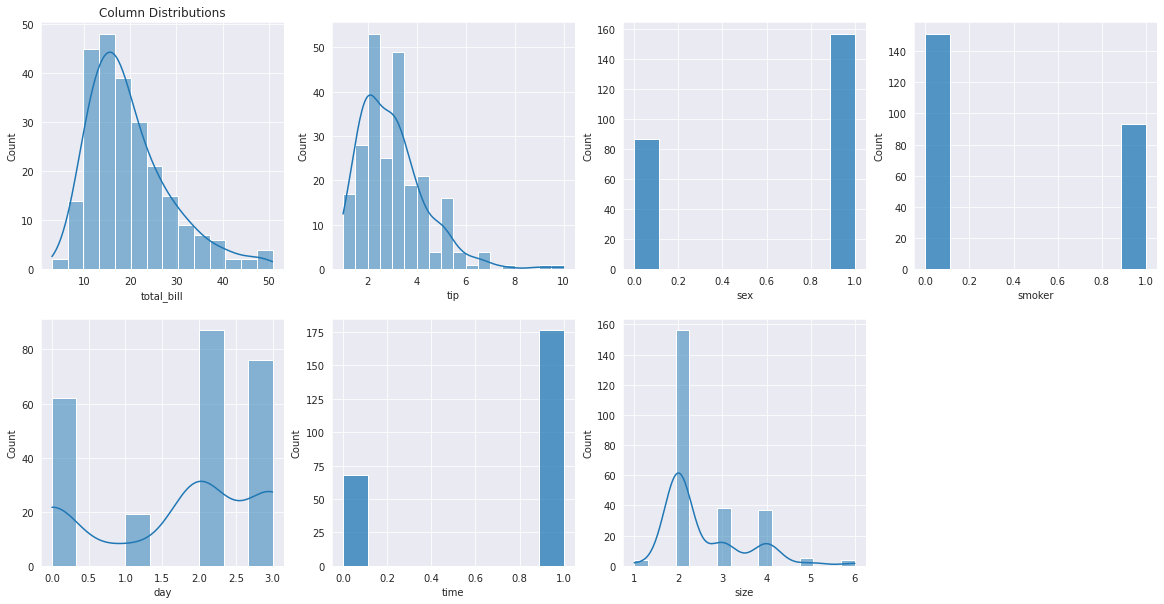

In [8]:
plt.figure(figsize=(20, 10))

# 총 7개의 variable에 대해 실행
for i in range(len(X.columns)):
    plt.subplot(2, 4, i + 1)   # 총 8개의 subplot을 만든다.
    if len(X[X.columns[i]].unique()) > 2:              # 한 변수에서의 데이터 값이 3개 이상이면,
        sns.histplot(X[X.columns[i]], kde=True)        # 그 변수에 대해 histplot을 그린다.
    else:
        sns.histplot(X[X.columns[i]], kde=False)
    if i == 0:
        plt.title("Column Distributions")
        
plt.show()

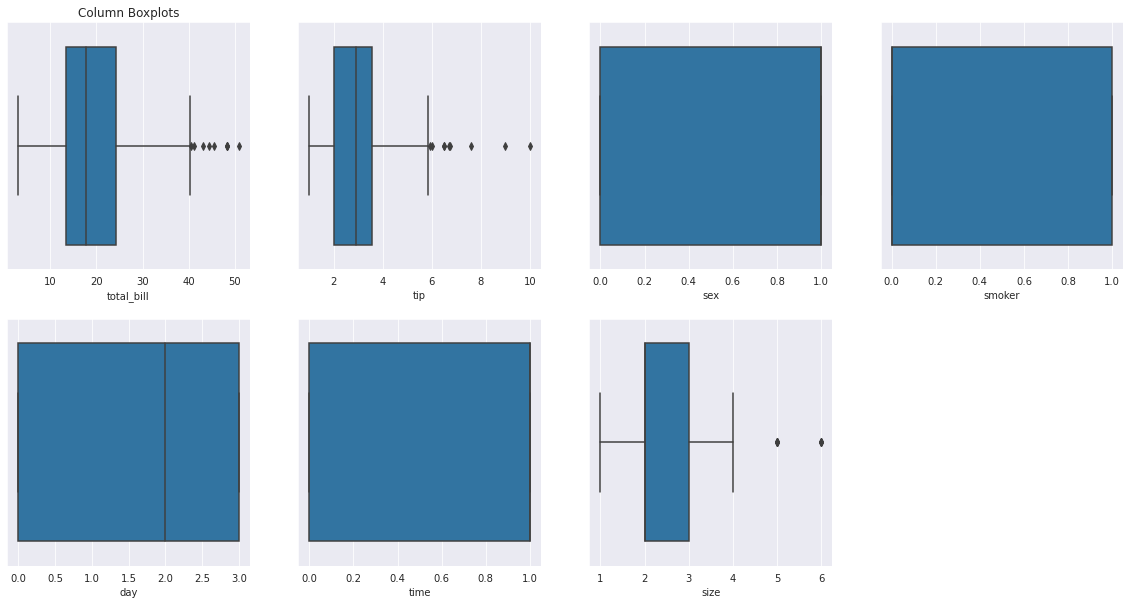

In [9]:
plt.figure(figsize=(20, 10))            # 그림 크기 20 by 10

for i in range(len(X.columns)):
    plt.subplot(2, 4, i + 1)
    sns.boxplot(x=X[X.columns[i]])
    if i == 0:
        plt.title("Column Boxplots")
        
plt.show()

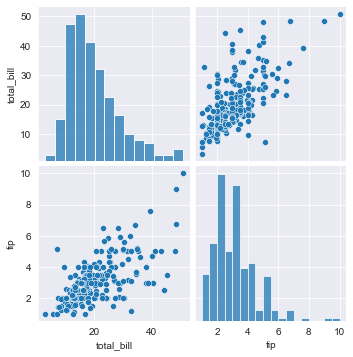

In [19]:
sns.pairplot(X.loc[:, ['total_bill', 'tip']])

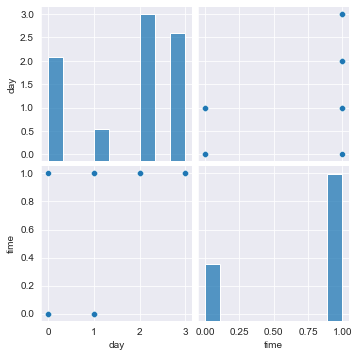

In [21]:
# day 와 time은 profiling에 의해서 high correlation 관계라고 했는데, 왜 이렇게 plot 시켰을 때에는 상관관계가 눈에 들어오지 않는지?
# day variable는 4개, time variable는 카테고리 변수라서? 그렇다면 어떻게 high correlation이 나올 수 있는지?

sns.pairplot(X.loc[:, ['day', 'time']])

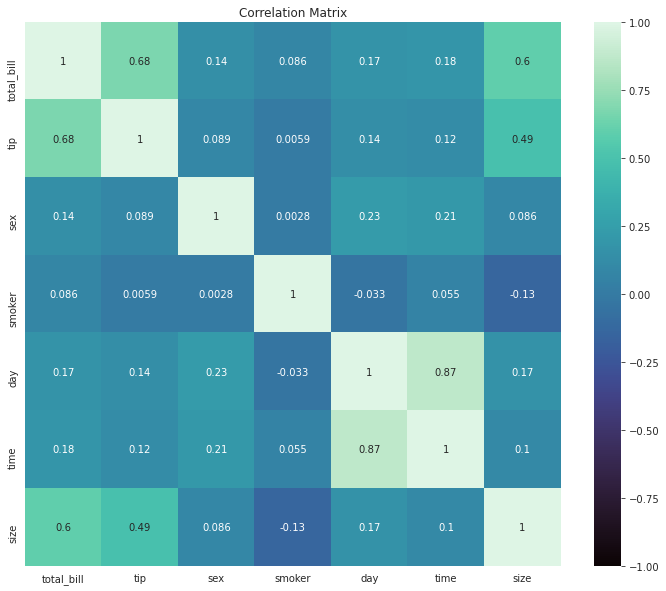

In [11]:
plt.figure(figsize=(12, 10))
sns.heatmap(X.corr(), annot=True, vmin=-1.0, cmap='mako')
plt.title("Correlation Matrix")
plt.show()

# 숫자로 인코딩 한것
#토탈빌은 3~100불
#sex는 0,1
# 범주형 데이터까지 인코딩을 해서 이렇게 만든것. tips_analysis의 correlation을 보면, 범주형 데이터는 생략이 되어 있다.
# 모델은 male, female 부분들은 인식을 못한다. 그래서 0,1 로 바꿔서 인식을 해야 한다.



# Training

In [12]:
X = X.sample(frac=1.0, random_state=1).reset_index(drop=True)

In [13]:
y = X['tip']
X = X.drop('tip', axis=1)

In [14]:
results = []
kf = KFold(n_splits=5)

for train_idx, test_idx in kf.split(X):
    
    X_train = X.iloc[train_idx, :]
    X_test = X.iloc[test_idx, :]
    y_train = y.iloc[train_idx]
    y_test = y.iloc[test_idx]
    
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    results.append(model.score(X_test, y_test))

# Results

In [15]:
for i in range(len(results)):
    print("Fold {}: {:.5f}".format(i + 1, results[i]))

print("\nAverage R^2 Score: {:.5f}".format(np.mean(results)))

Fold 1: 0.49755
Fold 2: -0.12224
Fold 3: 0.35517
Fold 4: 0.57015
Fold 5: 0.54927

Average R^2 Score: 0.36998


In [16]:
results

[0.49755299573499756,
 -0.12223894713164984,
 0.3551720639479413,
 0.5701460117958316,
 0.5492734419211263]

In [17]:
len(y_test)

48

In [18]:
y_test.max()

9.0

1 이번주 가장 많은 손님이 예상되는 요일은?

In [35]:
X['day']

0      2
1      0
2      2
3      0
4      0
      ..
239    0
240    2
241    0
242    2
243    2
Name: day, Length: 244, dtype: int64

In [57]:
X['day'].value_counts().max()

87

2 가장 많은 손님이 예상되는 요일에 no(#) 예상되는 팀수?

In [70]:
X.groupby(['day','size']).count()

total_bill  sex  smoker  time
day size                               
0   1              1    1       1     1
    2             48   48      48    48
    3              4    4       4     4
    4              5    5       5     5
    5              1    1       1     1
    6              3    3       3     3
1   1              1    1       1     1
    2             16   16      16    16
    3              1    1       1     1
    4              1    1       1     1
2   1              2    2       2     2
    2             53   53      53    53
    3             18   18      18    18
    4             13   13      13    13
    5              1    1       1     1
3   2             39   39      39    39
    3             15   15      15    15
    4             18   18      18    18
    5              3    3       3     3
    6              1    1       1     1

3 가장 많은 손님이 예상되는 요일의 예상 매출은?

In [ ]:
4 가장 많은 손님이 예상되는 요일의 예상 되는 tip $?

# Data Every Day  

This notebook is featured on Data Every Day, a YouTube series where I train models on a new dataset each day.  

***

Check it out!  
https://youtu.be/qCk8nKt2sS0